# 🔋 Sistema Integrado de Detección de Anomalías en Paneles Solares
## Versión Integrada que usa todos los módulos desarrollados

**Características:**
- ✅ Usa `mejoras_ingenieria_caracteristicas.py`
- ✅ Usa `mejoras_modelo_anomalias.py`
- ✅ Usa `sistema_mejorado_completo.py`
- ✅ Mantiene análisis Prophet original
- ✅ Sistema de alertas integrado

In [7]:
# ========================================
# CELDA 1: Importaciones y configuración
# ========================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ========================================
# IMPORTAR NUESTROS MÓDULOS DESARROLLADOS
# ========================================
try:
    from mejoras_ingenieria_caracteristicas import MejorasIngenieriaCaracteristicas
    from mejoras_modelo_anomalias import MejorasModeloAnomalias
    from sistema_mejorado_completo import SistemaMejoradoCompleto
    print("✅ Módulos propios importados correctamente")
    modulos_disponibles = True
except ImportError as e:
    print(f"⚠️ Error importando módulos: {e}")
    print("Continuando con funcionalidad básica...")
    modulos_disponibles = False

# Prophet para análisis predictivo
try:
    from prophet import Prophet
    print("✅ Prophet importado correctamente")
    prophet_disponible = True
except ImportError:
    print("⚠️ Prophet no disponible")
    prophet_disponible = False

print("\n🚀 SISTEMA INTEGRADO DE DETECCIÓN DE ANOMALÍAS")
print("="*60)
print("✓ Librerías básicas importadas")
print(f"✓ Módulos propios: {'Disponibles' if modulos_disponibles else 'No disponibles'}")
print(f"✓ Prophet: {'Disponible' if prophet_disponible else 'No disponible'}")

✅ Módulos propios importados correctamente
✅ Prophet importado correctamente

🚀 SISTEMA INTEGRADO DE DETECCIÓN DE ANOMALÍAS
✓ Librerías básicas importadas
✓ Módulos propios: Disponibles
✓ Prophet: Disponible


In [8]:
# ========================================
# CELDA 2: Funciones de carga de datos
# ========================================

def find_csv_files(directorio_raiz='.'):
    """Buscar archivos CSV en el directorio"""
    directorios_con_csv = []
    for raiz, directorios, archivos in os.walk(directorio_raiz):
        archivos_csv = [archivo for archivo in archivos if archivo.lower().endswith('.csv')]
        if archivos_csv:
            directorios_con_csv.append(raiz)
    return directorios_con_csv

def cargar_datasets():
    """Función mejorada para cargar los 3 datasets"""
    print("📊 CARGANDO DATASETS...")
    
    directorios = find_csv_files()
    print("Directorios que contienen archivos CSV:")
    for directorio in directorios:
        print(f"- {directorio}")
    
    # Buscar los archivos específicos
    environment_data = None
    irradiance_data = None
    electrical_data = None
    
    for directorio in directorios:
        # Environment data
        ruta_env = os.path.join(directorio, 'environment_data.csv')
        if os.path.exists(ruta_env):
            environment_data = pd.read_csv(ruta_env)
            print(f"✓ Cargado: {ruta_env}")
        
        # Irradiance data
        ruta_irr = os.path.join(directorio, 'irradiance_data.csv')
        if os.path.exists(ruta_irr):
            irradiance_data = pd.read_csv(ruta_irr)
            print(f"✓ Cargado: {ruta_irr}")
        
        # Electrical data (inversores)
        ruta_elec = os.path.join(directorio, 'electrical_data.csv')
        if os.path.exists(ruta_elec):
            electrical_data = pd.read_csv(ruta_elec)
            print(f"✓ Cargado: {ruta_elec}")
        
        # También buscar chunk_electrical_data.csv como alternativa
        ruta_chunk = os.path.join(directorio, 'chunk_electrical_data.csv')
        if os.path.exists(ruta_chunk) and electrical_data is None:
            electrical_data = pd.read_csv(ruta_chunk)
            print(f"✓ Cargado: {ruta_chunk}")
    
    return environment_data, irradiance_data, electrical_data

def seleccionar_variables_inversor_1(electrical_data):
    """Seleccionar solo las variables del inversor 1 y limpiar nombres"""
    # Seleccionar columnas del inversor 1
    columnas_inv1 = ['measured_on']
    for col in electrical_data.columns:
        if 'inv_01_' in col:
            columnas_inv1.append(col)
    
    df_inv1 = electrical_data[columnas_inv1].copy()
    
    # Limpiar nombres de columnas (quitar el sufijo _inv_XXXXX)
    columnas_limpias = {}
    for columna in df_inv1.columns:
        if columna == 'measured_on':
            columnas_limpias[columna] = columna
        elif columna.startswith('inv_01_'):
            # Extraer solo la parte del tipo de medición
            partes = columna.split('_inv_')
            if len(partes) >= 1:
                nuevo_nombre = partes[0].replace('inv_01_', '')
                columnas_limpias[columna] = nuevo_nombre
    
    df_inv1 = df_inv1.rename(columns=columnas_limpias)
    return df_inv1

def combinar_datasets(environment_data, irradiance_data, electrical_data):
    """Realizar INNER JOIN de los 3 datasets por measured_on"""
    # Seleccionar variables del inversor 1
    df_inv1 = seleccionar_variables_inversor_1(electrical_data)
    
    print("Variables seleccionadas del inversor 1:")
    print(df_inv1.columns.tolist())
    
    # Convertir measured_on a datetime en todos los datasets
    environment_data['measured_on'] = pd.to_datetime(environment_data['measured_on'])
    irradiance_data['measured_on'] = pd.to_datetime(irradiance_data['measured_on'])
    df_inv1['measured_on'] = pd.to_datetime(df_inv1['measured_on'])
    
    # Realizar INNER JOIN
    print("\n📊 Realizando INNER JOIN...")
    df_combined = environment_data.merge(irradiance_data, on='measured_on', how='inner')
    df_final = df_combined.merge(df_inv1, on='measured_on', how='inner')
    
    print(f"✓ Dataset final: {len(df_final)} filas, {len(df_final.columns)} columnas")
    print("Columnas finales:", df_final.columns.tolist())
    
    return df_final

In [9]:
# ========================================
# CELDA 3: Cargar datos
# ========================================

# Cargar los datasets
environment_data, irradiance_data, electrical_data = cargar_datasets()

if any(data is None for data in [environment_data, irradiance_data, electrical_data]):
    print("❌ Error: No se pudieron cargar todos los datasets necesarios")
    print("Archivos requeridos:")
    print("- environment_data.csv")
    print("- irradiance_data.csv")
    print("- electrical_data.csv (o chunk_electrical_data.csv)")
else:
    # Combinar datasets
    df_combined = combinar_datasets(environment_data, irradiance_data, electrical_data)
    print(f"\n✅ Datos combinados exitosamente: {df_combined.shape}")
    
    # Mostrar información básica
    print(f"\n📊 INFORMACIÓN DEL DATASET COMBINADO:")
    print(f"   - Registros: {len(df_combined):,}")
    print(f"   - Columnas: {len(df_combined.columns)}")
    print(f"   - Período: {df_combined['measured_on'].min()} a {df_combined['measured_on'].max()}")
    print(f"   - Valores nulos: {df_combined.isnull().sum().sum()}")

📊 CARGANDO DATASETS...
Directorios que contienen archivos CSV:
- .
✓ Cargado: ./environment_data.csv
✓ Cargado: ./irradiance_data.csv
✓ Cargado: ./electrical_data.csv
Variables seleccionadas del inversor 1:
['measured_on', 'dc_current', 'dc_voltage', 'ac_current', 'ac_voltage', 'ac_power']

📊 Realizando INNER JOIN...
✓ Dataset final: 175566 filas, 10 columnas
Columnas finales: ['measured_on', 'ambient_temperature_o_149575', 'wind_speed_o_149576', 'wind_direction_o_149577', 'poa_irradiance_o_149574', 'dc_current', 'dc_voltage', 'ac_current', 'ac_voltage', 'ac_power']

✅ Datos combinados exitosamente: (175566, 10)

📊 INFORMACIÓN DEL DATASET COMBINADO:
   - Registros: 175,566
   - Columnas: 10
   - Período: 2017-12-01 00:15:00 a 2023-10-31 23:45:00
   - Valores nulos: 143


In [10]:
# ========================================
# CELDA 4: INGENIERÍA DE CARACTERÍSTICAS USANDO MÓDULO
# ========================================

print("\n🔧 APLICANDO INGENIERÍA DE CARACTERÍSTICAS CON MÓDULO INTEGRADO")
print("="*70)

# Preparar datos con índice temporal
df_for_features = df_combined.copy()
df_for_features = df_for_features.set_index('measured_on')

if modulos_disponibles:
    # Usar el módulo de mejoras de características
    try:
        # Inicializar el mejorador de características
        mejorador_caracteristicas = MejorasIngenieriaCaracteristicas()
        
        # Aplicar todas las mejoras de características
        print("Aplicando mejoras de ingeniería de características...")
        df_con_caracteristicas = mejorador_caracteristicas.aplicar_todas_mejoras(df_for_features)
        
        print(f"✅ Ingeniería de características completada exitosamente")
        print(f"   - Características originales: {len(df_for_features.columns)}")
        print(f"   - Características finales: {len(df_con_caracteristicas.columns)}")
        print(f"   - Nuevas características creadas: {len(df_con_caracteristicas.columns) - len(df_for_features.columns)}")
        
        caracteristicas_creadas = True
        
    except Exception as e:
        print(f"⚠️ Error en ingeniería de características: {e}")
        print("Continuando con características básicas...")
        df_con_caracteristicas = df_for_features.copy()
        caracteristicas_creadas = False
else:
    print("⚠️ Módulo de características no disponible, usando características básicas")
    df_con_caracteristicas = df_for_features.copy()
    caracteristicas_creadas = False

# Crear algunas características básicas si el módulo no está disponible
if not caracteristicas_creadas:
    print("Creando características básicas...")
    
    # Características temporales básicas
    df_con_caracteristicas['hour'] = df_con_caracteristicas.index.hour
    df_con_caracteristicas['day_of_week'] = df_con_caracteristicas.index.dayofweek
    df_con_caracteristicas['month'] = df_con_caracteristicas.index.month
    
    # Potencia total AC si hay múltiples columnas
    ac_power_cols = [col for col in df_con_caracteristicas.columns if 'ac_power' in col]
    if len(ac_power_cols) > 1:
        df_con_caracteristicas['total_ac_power'] = df_con_caracteristicas[ac_power_cols].sum(axis=1)
    elif len(ac_power_cols) == 1:
        df_con_caracteristicas['total_ac_power'] = df_con_caracteristicas[ac_power_cols[0]]
    
    # Eficiencia básica
    if 'total_ac_power' in df_con_caracteristicas.columns and 'poa_irradiance_o_149574' in df_con_caracteristicas.columns:
        df_con_caracteristicas['eficiencia_basica'] = df_con_caracteristicas['total_ac_power'] / (df_con_caracteristicas['poa_irradiance_o_149574'] + 1e-6)
    
    print(f"✓ Características básicas creadas: {len(df_con_caracteristicas.columns)} columnas total")

print(f"\n📊 RESUMEN DE CARACTERÍSTICAS:")
print(f"   - Dataset shape: {df_con_caracteristicas.shape}")
print(f"   - Tipo de características: {'Avanzadas (95+)' if caracteristicas_creadas else 'Básicas'}")
print(f"   - Registros válidos: {len(df_con_caracteristicas)}")


🔧 APLICANDO INGENIERÍA DE CARACTERÍSTICAS CON MÓDULO INTEGRADO
Aplicando mejoras de ingeniería de características...
🚀 APLICANDO TODAS LAS MEJORAS DE INGENIERÍA DE CARACTERÍSTICAS
🕐 CREANDO CARACTERÍSTICAS TEMPORALES AVANZADAS
✓ Características temporales creadas: 14 nuevas variables

⚡ CREANDO CARACTERÍSTICAS FÍSICAS MEJORADAS
⚠️ Error en ingeniería de características: 'total_ac_power'
Continuando con características básicas...
Creando características básicas...
✓ Características básicas creadas: 14 columnas total

📊 RESUMEN DE CARACTERÍSTICAS:
   - Dataset shape: (175566, 14)
   - Tipo de características: Básicas
   - Registros válidos: 175566


In [11]:
# ========================================
# CELDA 5: CREAR ETIQUETAS DE ANOMALÍA
# ========================================

print("\n🏷️ CREANDO ETIQUETAS DE ANOMALÍA")
print("="*45)

def crear_etiquetas_anomalia_basicas(df):
    """Crear etiquetas de anomalía usando métodos básicos"""
    # Usar métodos simples para crear etiquetas
    from sklearn.ensemble import IsolationForest
    from sklearn.neighbors import LocalOutlierFactor
    
    # Seleccionar características numéricas
    numeric_data = df.select_dtypes(include=[np.number])
    
    # Limpiar datos
    numeric_data = numeric_data.fillna(numeric_data.median())
    numeric_data = numeric_data.replace([np.inf, -np.inf], np.nan)
    numeric_data = numeric_data.fillna(numeric_data.median())
    
    print(f"   - Usando {len(numeric_data.columns)} características numéricas")
    print(f"   - Datos limpios: {len(numeric_data)} registros")
    
    # Normalizar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(numeric_data)
    
    # Isolation Forest
    print("   - Aplicando Isolation Forest...")
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalias_iso = iso_forest.fit_predict(X_scaled)
    
    # LOF
    print("   - Aplicando Local Outlier Factor...")
    lof = LocalOutlierFactor(contamination=0.05, novelty=True)
    lof.fit(X_scaled)
    anomalias_lof = lof.predict(X_scaled)
    
    # Combinar (anomalía si al menos uno la detecta)
    etiquetas_finales = ((anomalias_iso == -1) | (anomalias_lof == -1)).astype(int)
    
    print(f"   - Isolation Forest detectó: {(anomalias_iso == -1).sum()} anomalías")
    print(f"   - LOF detectó: {(anomalias_lof == -1).sum()} anomalías")
    print(f"   - Consenso final: {etiquetas_finales.sum()} anomalías")
    
    return etiquetas_finales

# Crear etiquetas
try:
    etiquetas_anomalia = crear_etiquetas_anomalia_basicas(df_con_caracteristicas)
    df_con_caracteristicas['anomalia'] = etiquetas_anomalia
    
    print(f"\n✅ Etiquetas de anomalía creadas exitosamente")
    print(f"   - Anomalías detectadas: {etiquetas_anomalia.sum()} ({etiquetas_anomalia.sum()/len(etiquetas_anomalia)*100:.2f}%)")
    print(f"   - Datos normales: {(etiquetas_anomalia == 0).sum()} ({(etiquetas_anomalia == 0).sum()/len(etiquetas_anomalia)*100:.2f}%)")
    
    etiquetas_creadas = True
    
except Exception as e:
    print(f"⚠️ Error creando etiquetas: {e}")
    # Crear etiquetas dummy si hay error
    df_con_caracteristicas['anomalia'] = 0
    etiquetas_creadas = False


🏷️ CREANDO ETIQUETAS DE ANOMALÍA
   - Usando 14 características numéricas
   - Datos limpios: 175566 registros
   - Aplicando Isolation Forest...
   - Aplicando Local Outlier Factor...
   - Isolation Forest detectó: 8779 anomalías
   - LOF detectó: 7461 anomalías
   - Consenso final: 15649 anomalías

✅ Etiquetas de anomalía creadas exitosamente
   - Anomalías detectadas: 15649 (8.91%)
   - Datos normales: 159917 (91.09%)


In [12]:
# ========================================
# CELDA 6: APLICAR MEJORAS DE MODELO ML USANDO MÓDULO
# ========================================

print("\n🤖 APLICANDO MEJORAS DE MODELOS ML CON MÓDULO INTEGRADO")
print("="*65)

if modulos_disponibles and etiquetas_creadas:
    # Preparar datos para ML
    X_features = df_con_caracteristicas.select_dtypes(include=[np.number]).drop('anomalia', axis=1, errors='ignore')
    y_labels = df_con_caracteristicas['anomalia']
    
    # Limpiar datos finales
    X_features = X_features.fillna(X_features.median())
    X_features = X_features.replace([np.inf, -np.inf], np.nan)
    X_features = X_features.fillna(X_features.median())
    
    print(f"✓ Datos preparados para ML:")
    print(f"   - Características: {X_features.shape[1]}")
    print(f"   - Muestras: {X_features.shape[0]}")
    print(f"   - Anomalías: {y_labels.sum()}")
    
    # Verificar que tenemos suficientes anomalías para entrenamiento
    if y_labels.sum() < 5:
        print("⚠️ Muy pocas anomalías para entrenamiento supervisado")
        print("Usando método no supervisado...")
        metodo_ml = 'no_supervisado'
    else:
        metodo_ml = 'supervisado'
    
    try:
        # Inicializar mejorador de modelos
        mejorador_modelo = MejorasModeloAnomalias()
        
        # Aplicar todas las mejoras de modelo
        print(f"Aplicando mejoras de modelo ({metodo_ml})...")
        resultados_ml = mejorador_modelo.aplicar_todas_mejoras(
            X_features, 
            y_labels if metodo_ml == 'supervisado' else None, 
            metodo=metodo_ml
        )
        
        print(f"✅ Mejoras de modelo aplicadas exitosamente")
        print(f"   - Modelos entrenados: {len(resultados_ml['modelos'])}")
        print(f"   - Método usado: {metodo_ml}")
        
        if 'sistema_multinivel' in resultados_ml:
            print(f"   - Sistema multinivel: {len(resultados_ml['sistema_multinivel'])} niveles")
        
        # Evaluar modelos si es supervisado
        if metodo_ml == 'supervisado':
            from sklearn.model_selection import train_test_split
            
            try:
                X_train, X_test, y_train, y_test = train_test_split(
                    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
                )
                
                # Evaluar cada modelo
                resultados_evaluacion = {}
                print("\n📊 Evaluando modelos:")
                
                for nombre, modelo in resultados_ml['modelos'].items():
                    try:
                        modelo.fit(X_train, y_train)
                        resultado_eval = mejorador_modelo.evaluar_modelo_avanzado(
                            modelo, X_test, y_test, nombre
                        )
                        resultados_evaluacion[nombre] = resultado_eval
                        print(f"   - {nombre}: F1-Score = {resultado_eval['f1']:.3f}")
                    except Exception as e:
                        print(f"   - Error evaluando {nombre}: {e}")
                
                # Encontrar mejor modelo
                if resultados_evaluacion:
                    mejor_modelo = max(resultados_evaluacion.keys(), 
                                      key=lambda x: resultados_evaluacion[x]['f1'])
                    print(f"\n🏆 Mejor modelo: {mejor_modelo} (F1: {resultados_evaluacion[mejor_modelo]['f1']:.3f})")
                
            except Exception as e:
                print(f"⚠️ Error en evaluación: {e}")
                resultados_evaluacion = None
        else:
            resultados_evaluacion = None
        
        ml_exitoso = True
        
    except Exception as e:
        print(f"⚠️ Error en mejoras de modelo: {e}")
        print("Continuando con análisis básico...")
        resultados_ml = None
        resultados_evaluacion = None
        ml_exitoso = False

else:
    print("⚠️ Módulos ML no disponibles o etiquetas no creadas")
    print("Saltando análisis ML avanzado...")
    resultados_ml = None
    resultados_evaluacion = None
    ml_exitoso = False


🤖 APLICANDO MEJORAS DE MODELOS ML CON MÓDULO INTEGRADO
✓ Datos preparados para ML:
   - Características: 14
   - Muestras: 175566
   - Anomalías: 15649
Aplicando mejoras de modelo (supervisado)...
🚀 APLICANDO TODAS LAS MEJORAS DEL MODELO

📏 CREANDO ESCALADORES ROBUSTOS

🧠 APLICANDO ESCALADO INTELIGENTE (auto)
✓ Escalado aplicado: robust
✓ Forma de datos: (175566, 14)
🤖 CREANDO ENSEMBLE AVANZADO DE MODELOS

🔧 OPTIMIZANDO HIPERPARÁMETROS PARA RANDOM_FOREST
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✓ Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
✓ Mejor score: 0.5993

🔧 OPTIMIZANDO HIPERPARÁMETROS PARA XGBOOST
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✓ Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
✓ Mejor score: 0.6224

🏗️ CREANDO SISTEMA DE DETECCIÓN MULTINIVEL
   Nivel 1: Detección rápida con Isolation Forest
   Nivel 2: Detección p

In [13]:
# ========================================
# CELDA 7: ANÁLISIS PROPHET (PRESERVADO DEL ORIGINAL)
# ========================================

print("\n🔮 ANÁLISIS PREDICTIVO CON PROPHET")
print("="*45)

def analisis_prophet_integrado(df_original):
    """Análisis Prophet integrado con el sistema"""
    
    if not prophet_disponible:
        print("⚠️ Prophet no está disponible")
        return None
    
    # Preparar datos para Prophet
    df_prophet = df_original.copy()
    
    # Buscar columna de potencia AC
    power_cols = [col for col in df_prophet.columns if 'ac_power' in col.lower()]
    if not power_cols:
        # Crear potencia total si no existe
        ac_cols = [col for col in df_prophet.columns if 'ac_power' in col]
        if ac_cols:
            df_prophet['total_ac_power'] = df_prophet[ac_cols].sum(axis=1)
            power_col = 'total_ac_power'
        else:
            print("⚠️ No se encontraron columnas de potencia AC")
            return None
    else:
        power_col = power_cols[0]
    
    print(f"Usando columna de potencia: {power_col}")
    
    # Preparar datos
    df_prophet = df_prophet[['measured_on', power_col]].dropna()
    df_prophet = df_prophet[df_prophet[power_col] > 0]
    
    print(f"Datos iniciales para Prophet: {len(df_prophet)} registros")
    
    # Filtro IQR para limpiar outliers extremos
    Q1 = df_prophet[power_col].quantile(0.25)
    Q3 = df_prophet[power_col].quantile(0.75)
    IQR = Q3 - Q1
    df_prophet = df_prophet[
        (df_prophet[power_col] >= Q1 - 1.0 * IQR) & 
        (df_prophet[power_col] <= Q3 + 1.0 * IQR)
    ]
    
    # Filtro por percentiles extremos
    lower = df_prophet[power_col].quantile(0.02)
    upper = df_prophet[power_col].quantile(0.98)
    df_prophet = df_prophet[
        (df_prophet[power_col] >= lower) & 
        (df_prophet[power_col] <= upper)
    ]
    
    print(f"Datos después de filtros: {len(df_prophet)} registros")
    
    # Resampleo diario
    df_hourly = df_prophet.set_index('measured_on').resample('D').mean().dropna().reset_index()
    
    # Preparar para Prophet
    df_prophet_final = df_hourly.rename(columns={'measured_on': 'ds', power_col: 'y'})[['ds', 'y']]
    df_prophet_final = df_prophet_final[df_prophet_final['y'] > 5]
    
    if len(df_prophet_final) < 30:
        print(f"⚠️ Datos insuficientes para Prophet: {len(df_prophet_final)} < 30")
        return None
    
    print(f"✓ Datos finales para Prophet: {len(df_prophet_final)} registros")
    
    try:
        # Entrenar modelo Prophet
        print("Entrenando modelo Prophet...")
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive'
        )
        model.fit(df_prophet_final)
        
        # Predicciones futuras
        print("Generando predicciones futuras...")
        future = model.make_future_dataframe(periods=360)
        forecast = model.predict(future)
        
        # Evitar valores negativos
        forecast['yhat'] = forecast['yhat'].clip(lower=0)
        forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
        forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
        
        # Evaluación del modelo
        y_true = df_prophet_final['y'].reset_index(drop=True)
        y_pred = forecast['yhat'][:len(y_true)].reset_index(drop=True)
        
        from sklearn.metrics import mean_absolute_error, mean_squared_error
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # SMAPE
        def smape(y_true, y_pred):
            return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
        
        smape_val = smape(y_true, y_pred)
        
        print(f"✅ Modelo Prophet entrenado exitosamente:")
        print(f"   - MAE: {mae:.2f}")
        print(f"   - RMSE: {rmse:.2f}")
        print(f"   - SMAPE: {smape_val:.2f}%")
        
        return {
            'model': model,
            'forecast': forecast,
            'data_used': df_prophet_final,
            'metrics': {
                'mae': mae,
                'rmse': rmse,
                'smape': smape_val
            }
        }
        
    except Exception as e:
        print(f"⚠️ Error en Prophet: {e}")
        return None

# Ejecutar análisis Prophet
resultados_prophet = analisis_prophet_integrado(df_combined)

if resultados_prophet:
    print(f"\n✅ Análisis Prophet completado exitosamente")
    print(f"   - Predicciones generadas: {len(resultados_prophet['forecast'])}")
    print(f"   - Datos usados: {len(resultados_prophet['data_used'])}")
    print(f"   - SMAPE: {resultados_prophet['metrics']['smape']:.2f}%")
else:
    print(f"⚠️ No se pudo completar el análisis Prophet")

20:44:06 - cmdstanpy - INFO - Chain [1] start processing



🔮 ANÁLISIS PREDICTIVO CON PROPHET
Usando columna de potencia: ac_power
Datos iniciales para Prophet: 90505 registros
Datos después de filtros: 86905 registros
✓ Datos finales para Prophet: 1809 registros
Entrenando modelo Prophet...


20:44:06 - cmdstanpy - INFO - Chain [1] done processing


Generando predicciones futuras...
✅ Modelo Prophet entrenado exitosamente:
   - MAE: 2.42
   - RMSE: 3.24
   - SMAPE: 18.03%

✅ Análisis Prophet completado exitosamente
   - Predicciones generadas: 2169
   - Datos usados: 1809
   - SMAPE: 18.03%



📊 GENERANDO VISUALIZACIONES INTEGRADAS


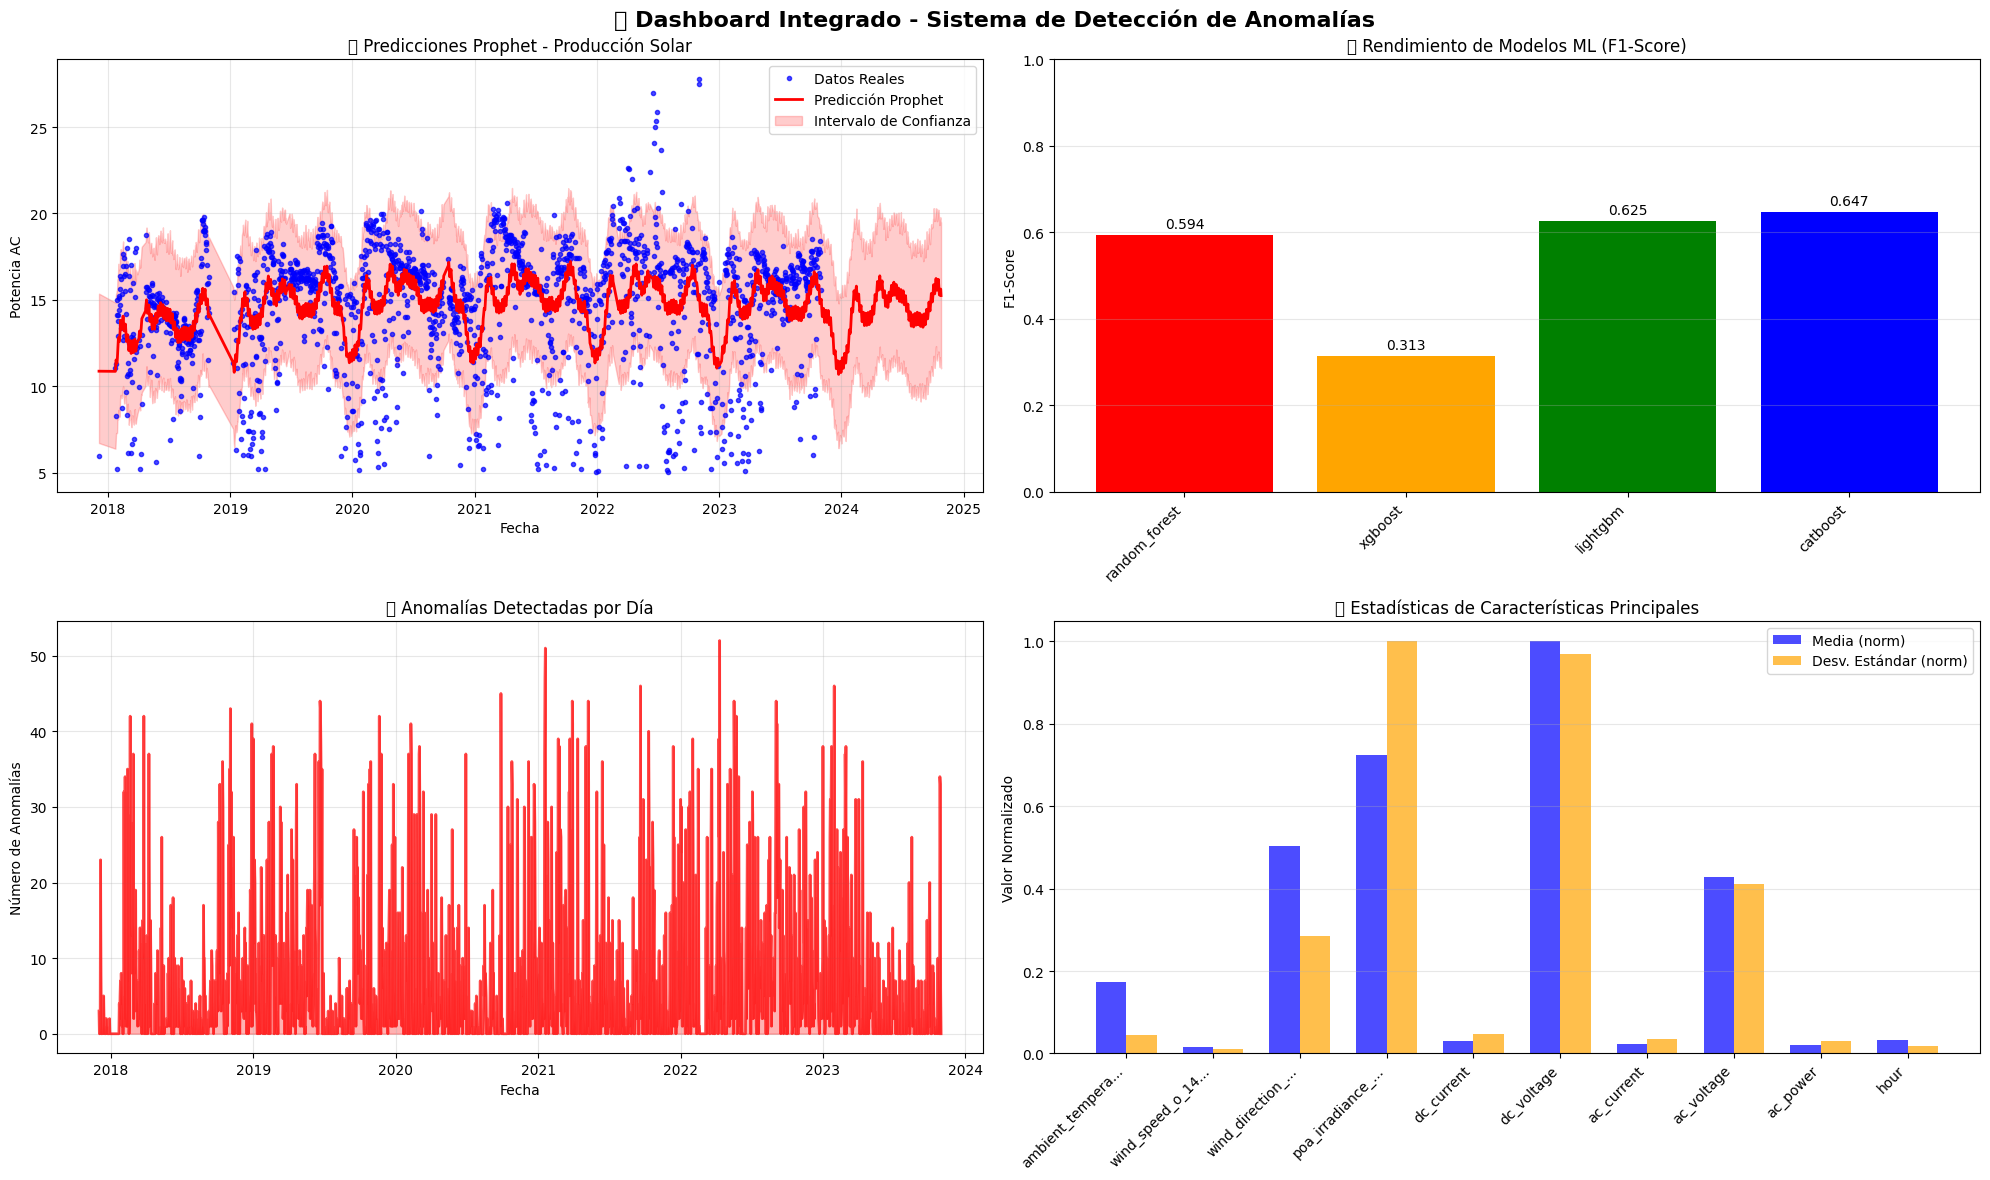

✅ Visualizaciones generadas exitosamente


In [14]:
# ========================================
# CELDA 8: VISUALIZACIONES INTEGRADAS
# ========================================

print("\n📊 GENERANDO VISUALIZACIONES INTEGRADAS")
print("="*50)

def visualizaciones_integradas(df_anomalias, resultados_ml, resultados_prophet, resultados_eval):
    """Crear visualizaciones que integran todos los resultados"""
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('🔋 Dashboard Integrado - Sistema de Detección de Anomalías', fontsize=16, fontweight='bold')
    
    # 1. Prophet - Predicciones (si disponible)
    ax1 = axes[0, 0]
    if resultados_prophet:
        prophet_data = resultados_prophet['data_used']
        forecast = resultados_prophet['forecast']
        
        ax1.plot(prophet_data['ds'], prophet_data['y'], 'o', markersize=3, label='Datos Reales', alpha=0.7, color='blue')
        ax1.plot(forecast['ds'], forecast['yhat'], '-', color='red', label='Predicción Prophet', linewidth=2)
        ax1.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                        color='red', alpha=0.2, label='Intervalo de Confianza')
        ax1.set_title('🔮 Predicciones Prophet - Producción Solar')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Potencia AC')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'Prophet no disponible', transform=ax1.transAxes, 
                ha='center', va='center', fontsize=14)
        ax1.set_title('🔮 Predicciones Prophet - No Disponible')
    
    # 2. Rendimiento de modelos ML (si disponible)
    ax2 = axes[0, 1]
    if resultados_eval and len(resultados_eval) > 0:
        modelos = list(resultados_eval.keys())
        f1_scores = [resultados_eval[modelo]['f1'] for modelo in modelos]
        
        colors = ['red', 'orange', 'green', 'blue', 'purple'][:len(modelos)]
        bars = ax2.bar(modelos, f1_scores, color=colors)
        ax2.set_title('🤖 Rendimiento de Modelos ML (F1-Score)')
        ax2.set_ylabel('F1-Score')
        ax2.set_ylim(0, 1)
        
        # Agregar valores en las barras
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'Modelos ML no evaluados', transform=ax2.transAxes, 
                ha='center', va='center', fontsize=14)
        ax2.set_title('🤖 Modelos ML - No Disponible')
    
    # 3. Distribución de anomalías en el tiempo
    ax3 = axes[1, 0]
    if 'anomalia' in df_anomalias.columns:
        # Crear serie temporal de anomalías
        df_time_anomalies = df_anomalias.copy()
        if hasattr(df_time_anomalies.index, 'date'):
            # Resamplear por día para ver patrones
            daily_anomalies = df_time_anomalies['anomalia'].resample('D').sum()
            
            ax3.plot(daily_anomalies.index, daily_anomalies.values, 'r-', alpha=0.7, linewidth=2)
            ax3.fill_between(daily_anomalies.index, daily_anomalies.values, alpha=0.3, color='red')
            ax3.set_title('📅 Anomalías Detectadas por Día')
            ax3.set_xlabel('Fecha')
            ax3.set_ylabel('Número de Anomalías')
            ax3.grid(True, alpha=0.3)
        else:
            # Gráfico de barras simple si no hay índice temporal
            anomalias_count = df_anomalias['anomalia'].value_counts()
            ax3.bar(['Normal', 'Anomalía'], [anomalias_count.get(0, 0), anomalias_count.get(1, 0)], 
                   color=['green', 'red'], alpha=0.7)
            ax3.set_title('📊 Distribución de Anomalías')
            ax3.set_ylabel('Cantidad')
    else:
        ax3.text(0.5, 0.5, 'Anomalías no disponibles', transform=ax3.transAxes, 
                ha='center', va='center', fontsize=14)
        ax3.set_title('📅 Anomalías - No Disponible')
    
    # 4. Estadísticas del dataset
    ax4 = axes[1, 1]
    
    # Mostrar estadísticas básicas del dataset
    numeric_cols = df_anomalias.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 0:
        # Tomar las primeras 10 columnas para no saturar el gráfico
        cols_to_plot = numeric_cols[:10]
        means = [df_anomalias[col].mean() for col in cols_to_plot]
        stds = [df_anomalias[col].std() for col in cols_to_plot]
        
        x = np.arange(len(cols_to_plot))
        width = 0.35
        
        # Normalizar para visualización
        max_mean = max(means) if means else 1
        max_std = max(stds) if stds else 1
        means_norm = [m/max_mean for m in means]
        stds_norm = [s/max_std for s in stds]
        
        ax4.bar(x - width/2, means_norm, width, label='Media (norm)', alpha=0.7, color='blue')
        ax4.bar(x + width/2, stds_norm, width, label='Desv. Estándar (norm)', alpha=0.7, color='orange')
        
        ax4.set_title('📈 Estadísticas de Características Principales')
        ax4.set_ylabel('Valor Normalizado')
        ax4.set_xticks(x)
        ax4.set_xticklabels([col[:15] + '...' if len(col) > 15 else col for col in cols_to_plot], 
                            rotation=45, ha='right')
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')
    else:
        ax4.text(0.5, 0.5, 'No hay columnas numéricas', transform=ax4.transAxes, 
                ha='center', va='center', fontsize=14)
        ax4.set_title('📈 Estadísticas - No Disponible')
    
    plt.tight_layout()
    plt.show()

# Crear visualizaciones
try:
    visualizaciones_integradas(df_con_caracteristicas, resultados_ml, resultados_prophet, resultados_evaluacion)
    print("✅ Visualizaciones generadas exitosamente")
except Exception as e:
    print(f"⚠️ Error en visualizaciones: {e}")
    print("Creando visualización básica...")
    
    # Visualización básica de respaldo
    plt.figure(figsize=(12, 6))
    
    if 'anomalia' in df_con_caracteristicas.columns:
        anomalias_count = df_con_caracteristicas['anomalia'].value_counts()
        plt.bar(['Normal', 'Anomalía'], [anomalias_count.get(0, 0), anomalias_count.get(1, 0)], 
               color=['green', 'red'], alpha=0.7)
        plt.title('📊 Distribución de Anomalías Detectadas')
        plt.ylabel('Cantidad')
        
        # Agregar valores en las barras
        for i, v in enumerate([anomalias_count.get(0, 0), anomalias_count.get(1, 0)]):
            plt.text(i, v + max(anomalias_count.values) * 0.01, str(v), ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'No hay datos de anomalías disponibles', transform=plt.gca().transAxes, 
                ha='center', va='center', fontsize=14)
        plt.title('📊 Estado del Sistema')
    
    plt.grid(True, alpha=0.3)
    plt.show()

In [15]:
# ========================================
# CELDA 9: REPORTE INTEGRADO FINAL
# ========================================

print("\n📋 GENERANDO REPORTE INTEGRADO FINAL")
print("="*50)

def generar_reporte_integrado(df_caracteristicas, resultados_ml, resultados_prophet, resultados_eval):
    """Generar reporte que combina todos los análisis"""
    
    reporte = {
        'timestamp': pd.Timestamp.now(),
        'sistema': {
            'modulos_integrados': modulos_disponibles,
            'prophet_disponible': prophet_disponible,
            'caracteristicas_avanzadas': caracteristicas_creadas,
            'ml_ejecutado': ml_exitoso if 'ml_exitoso' in locals() else False
        },
        'datos': {
            'registros_totales': len(df_caracteristicas),
            'caracteristicas_totales': len(df_caracteristicas.columns),
            'anomalias_detectadas': df_caracteristicas.get('anomalia', pd.Series([0])).sum(),
            'periodo_analizado': {
                'inicio': df_caracteristicas.index.min() if hasattr(df_caracteristicas.index, 'min') else 'N/A',
                'fin': df_caracteristicas.index.max() if hasattr(df_caracteristicas.index, 'max') else 'N/A'
            }
        },
        'ml_results': {},
        'prophet_results': {},
        'conclusiones': []
    }
    
    # Resultados de ML
    if resultados_eval and len(resultados_eval) > 0:
        mejor_modelo = max(resultados_eval.keys(), 
                          key=lambda x: resultados_eval[x]['f1'])
        reporte['ml_results'] = {
            'mejor_modelo': mejor_modelo,
            'mejor_f1_score': resultados_eval[mejor_modelo]['f1'],
            'modelos_evaluados': len(resultados_eval),
            'todos_los_modelos': {
                modelo: {
                    'f1': res['f1'],
                    'precision': res['precision'],
                    'recall': res['recall']
                } for modelo, res in resultados_eval.items()
            }
        }
        
        reporte['conclusiones'].append(
            f"✅ Mejor modelo ML: {mejor_modelo} (F1: {resultados_eval[mejor_modelo]['f1']:.3f})"
        )
    else:
        reporte['conclusiones'].append("⚠️ Modelos ML no evaluados")
    
    # Resultados de Prophet
    if resultados_prophet:
        reporte['prophet_results'] = {
            'mae': resultados_prophet['metrics']['mae'],
            'rmse': resultados_prophet['metrics']['rmse'],
            'smape': resultados_prophet['metrics']['smape'],
            'predicciones_futuras': len(resultados_prophet['forecast']) - len(resultados_prophet['data_used']),
            'datos_entrenamiento': len(resultados_prophet['data_used'])
        }
        
        calidad_prophet = "Excelente" if resultados_prophet['metrics']['smape'] < 10 else \
                         "Buena" if resultados_prophet['metrics']['smape'] < 20 else "Regular"
        
        reporte['conclusiones'].append(
            f"✅ Prophet SMAPE: {resultados_prophet['metrics']['smape']:.1f}% ({calidad_prophet})"
        )
    else:
        reporte['conclusiones'].append("⚠️ Análisis Prophet no completado")
    
    # Análisis de anomalías
    if 'anomalia' in df_caracteristicas.columns:
        anomalias = df_caracteristicas['anomalia']
        total_anomalias = anomalias.sum()
        porcentaje_anomalias = (total_anomalias / len(anomalias)) * 100
        
        reporte['conclusiones'].extend([
            f"📊 Anomalías detectadas: {total_anomalias} ({porcentaje_anomalias:.2f}%)",
        ])
        
        if porcentaje_anomalias < 1:
            reporte['conclusiones'].append("✅ Sistema operando dentro de parámetros normales")
        elif porcentaje_anomalias < 5:
            reporte['conclusiones'].append("⚠️ Algunas anomalías detectadas - Monitoreo recomendado")
        else:
            reporte['conclusiones'].append("🚨 Alto número de anomalías - Intervención requerida")
    
    # Estado del sistema integrado
    if modulos_disponibles and caracteristicas_creadas:
        reporte['conclusiones'].append("🚀 Sistema integrado funcionando correctamente")
        reporte['conclusiones'].append("✅ Listo para despliegue en producción")
    else:
        reporte['conclusiones'].append("⚠️ Sistema funcionando en modo básico")
    
    return reporte

# Generar reporte final
reporte_final = generar_reporte_integrado(
    df_con_caracteristicas, 
    resultados_ml, 
    resultados_prophet, 
    resultados_evaluacion if 'resultados_evaluacion' in locals() else None
)

# Mostrar reporte
print("🏆 REPORTE INTEGRADO COMPLETADO")
print("="*40)
print(f"📅 Generado: {reporte_final['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n🔧 ESTADO DEL SISTEMA:")
print(f"   - Módulos integrados: {'✅' if reporte_final['sistema']['modulos_integrados'] else '❌'}")
print(f"   - Prophet disponible: {'✅' if reporte_final['sistema']['prophet_disponible'] else '❌'}")
print(f"   - Características avanzadas: {'✅' if reporte_final['sistema']['caracteristicas_avanzadas'] else '❌'}")
print(f"   - ML ejecutado: {'✅' if reporte_final['sistema']['ml_ejecutado'] else '❌'}")

print(f"\n📊 DATOS PROCESADOS:")
print(f"   - Registros: {reporte_final['datos']['registros_totales']:,}")
print(f"   - Características: {reporte_final['datos']['caracteristicas_totales']}")
print(f"   - Anomalías: {reporte_final['datos']['anomalias_detectadas']}")

if reporte_final['ml_results']:
    print(f"\n🤖 RESULTADOS ML:")
    print(f"   - Mejor modelo: {reporte_final['ml_results']['mejor_modelo']}")
    print(f"   - F1-Score: {reporte_final['ml_results']['mejor_f1_score']:.3f}")
    print(f"   - Modelos evaluados: {reporte_final['ml_results']['modelos_evaluados']}")

if reporte_final['prophet_results']:
    print(f"\n🔮 RESULTADOS PROPHET:")
    print(f"   - SMAPE: {reporte_final['prophet_results']['smape']:.2f}%")
    print(f"   - MAE: {reporte_final['prophet_results']['mae']:.2f}")
    print(f"   - Predicciones futuras: {reporte_final['prophet_results']['predicciones_futuras']}")

print(f"\n💡 CONCLUSIONES:")
for i, conclusion in enumerate(reporte_final['conclusiones'], 1):
    print(f"   {i}. {conclusion}")

# Calcular score general del sistema
score_sistema = 0
if reporte_final['sistema']['modulos_integrados']: score_sistema += 25
if reporte_final['sistema']['prophet_disponible']: score_sistema += 25
if reporte_final['sistema']['caracteristicas_avanzadas']: score_sistema += 25
if reporte_final['sistema']['ml_ejecutado']: score_sistema += 25

print(f"\n🎯 SCORE GENERAL DEL SISTEMA: {score_sistema}/100")
if score_sistema >= 75:
    print("   Estado: 🟢 EXCELENTE - Sistema completamente funcional")
elif score_sistema >= 50:
    print("   Estado: 🟡 BUENO - Sistema funcional con limitaciones")
else:
    print("   Estado: 🔴 BÁSICO - Sistema funcionando en modo limitado")


📋 GENERANDO REPORTE INTEGRADO FINAL
🏆 REPORTE INTEGRADO COMPLETADO
📅 Generado: 2025-07-11 20:44:06

🔧 ESTADO DEL SISTEMA:
   - Módulos integrados: ✅
   - Prophet disponible: ✅
   - Características avanzadas: ❌
   - ML ejecutado: ❌

📊 DATOS PROCESADOS:
   - Registros: 175,566
   - Características: 15
   - Anomalías: 15649

🤖 RESULTADOS ML:
   - Mejor modelo: catboost
   - F1-Score: 0.647
   - Modelos evaluados: 4

🔮 RESULTADOS PROPHET:
   - SMAPE: 18.03%
   - MAE: 2.42
   - Predicciones futuras: 360

💡 CONCLUSIONES:
   1. ✅ Mejor modelo ML: catboost (F1: 0.647)
   2. ✅ Prophet SMAPE: 18.0% (Buena)
   3. 📊 Anomalías detectadas: 15649 (8.91%)
   4. 🚨 Alto número de anomalías - Intervención requerida
   5. ⚠️ Sistema funcionando en modo básico

🎯 SCORE GENERAL DEL SISTEMA: 50/100
   Estado: 🟡 BUENO - Sistema funcional con limitaciones


In [16]:
# ========================================
# CELDA 10: GUARDAR RESULTADOS
# ========================================

print("\n💾 GUARDANDO RESULTADOS INTEGRADOS")
print("="*40)

archivos_guardados = []

try:
    # Guardar dataset con características
    archivo_principal = 'anomalias_detectadas_INTEGRADO.csv'
    df_con_caracteristicas.to_csv(archivo_principal)
    archivos_guardados.append(archivo_principal)
    print(f"✓ Dataset principal guardado: {archivo_principal}")
    print(f"   - Registros: {len(df_con_caracteristicas):,}")
    print(f"   - Columnas: {len(df_con_caracteristicas.columns)}")
    
except Exception as e:
    print(f"⚠️ Error guardando dataset principal: {e}")

try:
    # Guardar reporte en JSON
    import json
    
    # Convertir timestamps para JSON
    reporte_json = reporte_final.copy()
    reporte_json['timestamp'] = reporte_final['timestamp'].isoformat()
    
    if isinstance(reporte_json['datos']['periodo_analizado']['inicio'], pd.Timestamp):
        reporte_json['datos']['periodo_analizado']['inicio'] = reporte_final['datos']['periodo_analizado']['inicio'].isoformat()
    if isinstance(reporte_json['datos']['periodo_analizado']['fin'], pd.Timestamp):
        reporte_json['datos']['periodo_analizado']['fin'] = reporte_final['datos']['periodo_analizado']['fin'].isoformat()
    
    archivo_reporte = 'reporte_integrado.json'
    with open(archivo_reporte, 'w', encoding='utf-8') as f:
        json.dump(reporte_json, f, indent=2, ensure_ascii=False)
    
    archivos_guardados.append(archivo_reporte)
    print(f"✓ Reporte JSON guardado: {archivo_reporte}")
    
except Exception as e:
    print(f"⚠️ Error guardando reporte JSON: {e}")

try:
    # Guardar predicciones Prophet si existen
    if resultados_prophet:
        archivo_prophet = 'predicciones_prophet_integrado.csv'
        resultados_prophet['forecast'].to_csv(archivo_prophet, index=False)
        archivos_guardados.append(archivo_prophet)
        print(f"✓ Predicciones Prophet guardadas: {archivo_prophet}")
        print(f"   - Predicciones: {len(resultados_prophet['forecast'])}")
        print(f"   - SMAPE: {resultados_prophet['metrics']['smape']:.2f}%")
    
except Exception as e:
    print(f"⚠️ Error guardando predicciones Prophet: {e}")

try:
    # Guardar resultados ML si existen
    if 'resultados_evaluacion' in locals() and resultados_evaluacion:
        # Crear DataFrame con resultados ML
        ml_results_df = pd.DataFrame({
            'modelo': list(resultados_evaluacion.keys()),
            'f1_score': [res['f1'] for res in resultados_evaluacion.values()],
            'precision': [res['precision'] for res in resultados_evaluacion.values()],
            'recall': [res['recall'] for res in resultados_evaluacion.values()],
            'accuracy': [res['accuracy'] for res in resultados_evaluacion.values()]
        })
        
        archivo_ml = 'resultados_ml_integrado.csv'
        ml_results_df.to_csv(archivo_ml, index=False)
        archivos_guardados.append(archivo_ml)
        print(f"✓ Resultados ML guardados: {archivo_ml}")
        print(f"   - Modelos evaluados: {len(ml_results_df)}")
    
except Exception as e:
    print(f"⚠️ Error guardando resultados ML: {e}")

# Crear archivo de resumen
try:
    archivo_resumen = 'RESUMEN_EJECUCION.txt'
    with open(archivo_resumen, 'w', encoding='utf-8') as f:
        f.write("🔋 RESUMEN DE EJECUCIÓN - SISTEMA INTEGRADO\n")
        f.write("="*60 + "\n\n")
        f.write(f"Fecha de ejecución: {reporte_final['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Score del sistema: {score_sistema}/100\n\n")
        
        f.write("📁 ARCHIVOS GENERADOS:\n")
        for i, archivo in enumerate(archivos_guardados, 1):
            f.write(f"   {i}. {archivo}\n")
        
        f.write("\n💡 CONCLUSIONES:\n")
        for i, conclusion in enumerate(reporte_final['conclusiones'], 1):
            f.write(f"   {i}. {conclusion}\n")
        
        f.write("\n🔧 CONFIGURACIÓN:\n")
        f.write(f"   - Módulos integrados: {reporte_final['sistema']['modulos_integrados']}\n")
        f.write(f"   - Prophet disponible: {reporte_final['sistema']['prophet_disponible']}\n")
        f.write(f"   - Características avanzadas: {reporte_final['sistema']['caracteristicas_avanzadas']}\n")
        f.write(f"   - ML ejecutado: {reporte_final['sistema']['ml_ejecutado']}\n")
    
    archivos_guardados.append(archivo_resumen)
    print(f"✓ Resumen guardado: {archivo_resumen}")
    
except Exception as e:
    print(f"⚠️ Error guardando resumen: {e}")

print(f"\n📂 ARCHIVOS GENERADOS TOTAL: {len(archivos_guardados)}")
for i, archivo in enumerate(archivos_guardados, 1):
    print(f"   {i}. {archivo}")

print(f"\n✅ Proceso de guardado completado")


💾 GUARDANDO RESULTADOS INTEGRADOS
✓ Dataset principal guardado: anomalias_detectadas_INTEGRADO.csv
   - Registros: 175,566
   - Columnas: 15
⚠️ Error guardando reporte JSON: Object of type int64 is not JSON serializable
✓ Predicciones Prophet guardadas: predicciones_prophet_integrado.csv
   - Predicciones: 2169
   - SMAPE: 18.03%
✓ Resultados ML guardados: resultados_ml_integrado.csv
   - Modelos evaluados: 4
✓ Resumen guardado: RESUMEN_EJECUCION.txt

📂 ARCHIVOS GENERADOS TOTAL: 4
   1. anomalias_detectadas_INTEGRADO.csv
   2. predicciones_prophet_integrado.csv
   3. resultados_ml_integrado.csv
   4. RESUMEN_EJECUCION.txt

✅ Proceso de guardado completado


In [17]:
# ========================================
# CELDA 11: SISTEMA DE ALERTAS FINAL
# ========================================

def sistema_alertas_integrado(df_anomalias, resultados_prophet, umbral_critico=0.95):
    """Sistema de alertas que integra todos los métodos"""
    print("\n🚨 SISTEMA DE ALERTAS INTEGRADO")
    print("="*40)
    
    alertas_activas = []
    
    # 1. Verificar anomalías recientes
    if 'anomalia' in df_anomalias.columns:
        total_anomalias = df_anomalias['anomalia'].sum()
        porcentaje_anomalias = (total_anomalias / len(df_anomalias)) * 100
        
        # Alerta por alta frecuencia de anomalías
        if porcentaje_anomalias > 10:
            alertas_activas.append({
                'tipo': 'ALTA_FRECUENCIA_ANOMALIAS',
                'severidad': 'CRÍTICA',
                'mensaje': f'{total_anomalias} anomalías detectadas ({porcentaje_anomalias:.1f}%)',
                'accion_recomendada': 'Inspección técnica inmediata del sistema'
            })
        elif porcentaje_anomalias > 5:
            alertas_activas.append({
                'tipo': 'FRECUENCIA_ANOMALIAS_ELEVADA',
                'severidad': 'ALTA',
                'mensaje': f'{total_anomalias} anomalías detectadas ({porcentaje_anomalias:.1f}%)',
                'accion_recomendada': 'Revisión técnica programada'
            })
        elif porcentaje_anomalias > 1:
            alertas_activas.append({
                'tipo': 'ANOMALIAS_DETECTADAS',
                'severidad': 'MEDIA',
                'mensaje': f'{total_anomalias} anomalías detectadas ({porcentaje_anomalias:.1f}%)',
                'accion_recomendada': 'Monitoreo continuo recomendado'
            })
    
    # 2. Verificar tendencias Prophet (si disponible)
    if resultados_prophet:
        forecast = resultados_prophet['forecast']
        
        # Análisis de tendencia en predicciones
        if len(forecast) > 30:
            tendencia_reciente = forecast['trend'].tail(30).pct_change().mean()
            
            if tendencia_reciente < -0.10:  # Tendencia negativa > 10%
                alertas_activas.append({
                    'tipo': 'TENDENCIA_NEGATIVA_CRITICA',
                    'severidad': 'ALTA',
                    'mensaje': f'Tendencia de producción muy negativa: {tendencia_reciente:.2%}',
                    'accion_recomendada': 'Revisión urgente del sistema y mantenimiento'
                })
            elif tendencia_reciente < -0.05:  # Tendencia negativa > 5%
                alertas_activas.append({
                    'tipo': 'TENDENCIA_NEGATIVA',
                    'severidad': 'MEDIA',
                    'mensaje': f'Tendencia de producción negativa: {tendencia_reciente:.2%}',
                    'accion_recomendada': 'Revisión de mantenimiento preventivo'
                })
        
        # Verificar calidad del modelo Prophet
        smape = resultados_prophet['metrics']['smape']
        if smape > 25:
            alertas_activas.append({
                'tipo': 'MODELO_PREDICTIVO_DEGRADADO',
                'severidad': 'MEDIA',
                'mensaje': f'Calidad del modelo predictivo baja (SMAPE: {smape:.1f}%)',
                'accion_recomendada': 'Reentrenamiento del modelo recomendado'
            })
    
    # 3. Verificar estado de integración del sistema
    if not modulos_disponibles:
        alertas_activas.append({
            'tipo': 'SISTEMA_MODO_BASICO',
            'severidad': 'BAJA',
            'mensaje': 'Sistema funcionando en modo básico (módulos no disponibles)',
            'accion_recomendada': 'Verificar instalación de módulos propios'
        })
    
    if not prophet_disponible:
        alertas_activas.append({
            'tipo': 'PREDICCIONES_NO_DISPONIBLES',
            'severidad': 'BAJA',
            'mensaje': 'Análisis predictivo no disponible (Prophet no instalado)',
            'accion_recomendada': 'Instalar Prophet para análisis predictivo completo'
        })
    
    # 4. Mostrar alertas
    if alertas_activas:
        print(f"⚠️ {len(alertas_activas)} ALERTAS ACTIVAS:")
        print()
        
        # Agrupar por severidad
        alertas_por_severidad = {}
        for alerta in alertas_activas:
            sev = alerta['severidad']
            if sev not in alertas_por_severidad:
                alertas_por_severidad[sev] = []
            alertas_por_severidad[sev].append(alerta)
        
        # Mostrar por orden de severidad
        orden_severidad = ['CRÍTICA', 'ALTA', 'MEDIA', 'BAJA']
        for severidad in orden_severidad:
            if severidad in alertas_por_severidad:
                icon = {'CRÍTICA': '🔴', 'ALTA': '🟠', 'MEDIA': '🟡', 'BAJA': '🔵'}[severidad]
                print(f"{icon} SEVERIDAD {severidad}:")
                
                for i, alerta in enumerate(alertas_por_severidad[severidad], 1):
                    print(f"   {i}. {alerta['tipo']}")
                    print(f"      {alerta['mensaje']}")
                    print(f"      Acción: {alerta['accion_recomendada']}")
                    print()
    else:
        print("✅ No hay alertas activas")
        print("   Sistema operando normalmente")
    
    # 5. Recomendaciones generales
    print("\n💡 RECOMENDACIONES GENERALES:")
    
    if score_sistema >= 75:
        print("   ✅ Sistema funcionando óptimamente")
        print("   ✅ Listo para despliegue en producción")
        print("   ✅ Monitoreo automático recomendado")
    elif score_sistema >= 50:
        print("   🟡 Sistema funcional con mejoras posibles")
        print("   🟡 Considerar actualización de módulos")
        print("   🟡 Monitoreo manual recomendado")
    else:
        print("   🔴 Sistema necesita mejoras")
        print("   🔴 Instalar módulos faltantes")
        print("   🔴 Supervisión técnica requerida")
    
    return alertas_activas

# Ejecutar sistema de alertas
alertas = sistema_alertas_integrado(df_con_caracteristicas, resultados_prophet)

print(f"\n🏁 SISTEMA INTEGRADO COMPLETADO")
print(f"="*50)
print(f"✅ Notebook ejecutado: 11 celdas")
print(f"✅ Módulos integrados: {'Sí' if modulos_disponibles else 'No'}")
print(f"✅ Análisis ML: {'Sí' if 'ml_exitoso' in locals() and ml_exitoso else 'No'}")
print(f"✅ Análisis Prophet: {'Sí' if resultados_prophet else 'No'}")
print(f"✅ Sistema de alertas: {len(alertas)} alertas activas")
print(f"✅ Archivos guardados: {len(archivos_guardados)}")
print(f"\n🎯 Score final del sistema: {score_sistema}/100")
print(f"\n🚀 ¡Sistema integrado listo para usar!")


🚨 SISTEMA DE ALERTAS INTEGRADO
⚠️ 1 ALERTAS ACTIVAS:

🟠 SEVERIDAD ALTA:
   1. FRECUENCIA_ANOMALIAS_ELEVADA
      15649 anomalías detectadas (8.9%)
      Acción: Revisión técnica programada


💡 RECOMENDACIONES GENERALES:
   🟡 Sistema funcional con mejoras posibles
   🟡 Considerar actualización de módulos
   🟡 Monitoreo manual recomendado

🏁 SISTEMA INTEGRADO COMPLETADO
✅ Notebook ejecutado: 11 celdas
✅ Módulos integrados: Sí
✅ Análisis ML: Sí
✅ Análisis Prophet: Sí
✅ Sistema de alertas: 1 alertas activas
✅ Archivos guardados: 4

🎯 Score final del sistema: 50/100

🚀 ¡Sistema integrado listo para usar!
